In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os
import copy
import holidays
import datetime as dt
from datetime import timedelta
os.getcwd()
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
from catboost import CatBoostClassifier

import shap
shap.initjs()

pd.set_option('display.max_columns', 70)

In [2]:
# read in punctuality data
punct2019_1 = pd.read_csv("./data/Punctuality_2019_part1.csv", sep = ";")
punct2019_2 = pd.read_csv("./data/Punctuality_2019_part2.csv", sep = ";")
punct2020_1 = pd.read_csv("./data/Punctuality_2020_part1.csv", sep = ";")
punct2020_2 = pd.read_csv("./data/Punctuality_2020_part2.csv", sep = ";")
punct2021_1 = pd.read_csv("./data/Punctuality_2021_part1.csv", sep = ";")
punct2021_2 = pd.read_csv("./data/Punctuality_2021_part2.csv", sep = ";")
punct2022_1 = pd.read_csv("./data/Punctuality_2022_part1.csv", sep = ";")
punct2022_2 = pd.read_csv("./data/Punctuality_2022_part2.csv", sep = ";")
punct2023 = pd.read_csv("./data/Punctuality_2023.csv", sep = ";")
all_punct = pd.concat([punct2019_1, punct2019_2, punct2020_1, punct2020_2, punct2021_1, punct2021_2, punct2022_1, punct2022_2, punct2023], axis = 0)
all_punct = all_punct[all_punct['TRAIN_ID'].notna()].reset_index()

# read in justifications data
justifs = pd.read_parquet("~/Downloads/justif_parquet")
justifs = justifs[justifs['TRAIN_ID_resp'].notna()]
justifs['p_resp'] = justifs['trno_resp'].apply(lambda x: 1 if ((x >= 7000) & (x <= 8999)) else 0)

# duplicate columns of interest to update with info from the train that was ultimately responsable for the knock-on delay
justifs['justification_dt_originator'] = justifs['justification_dt']
justifs['trno_resp_originator'] = justifs['trno_resp']
justifs['TRAIN_ID_resp_originator'] = justifs['TRAIN_ID_resp']


## Getting the label - preparation: we transform justifs to account for knock-on delays

In [5]:
# read file
justifs = pd.read_parquet("~/Downloads/justifs_originated/justifs_originated_5min.parquet")

In [6]:
# check potential overlap (in reality can be even more as uniqueness is not required)

unique_impacted = pd.unique(justifs['REF_TOD_IMPACTED_TRAIN'])
unique_responsible_originator = pd.unique(justifs['TRAIN_ID_resp_originator'])
print(len(unique_impacted)) # 293355
print(len(unique_responsible_originator)) # 268046
#common_elements = [element for element in unique_responsible_originator if element in unique_impacted] # takes a minute
#print(len(common_elements)) # 112818

293355
251939


In [7]:
justifs[['DEPARTURE_DT', 'TRAIN_NUMBER', 'REF_TOD_IMPACTED_TRAIN', 'JUSTIFIED_DIFFERENTIAL_DELAY', 'justification_dt',
         'trno_resp', 'TRAIN_ID_resp', 'justification_dt_originator', 'trno_resp_originator', 'TRAIN_ID_resp_originator']]

,DEPARTURE_DT,TRAIN_NUMBER,REF_TOD_IMPACTED_TRAIN,JUSTIFIED_DIFFERENTIAL_DELAY,justification_dt,trno_resp,TRAIN_ID_resp,justification_dt_originator,trno_resp_originator,TRAIN_ID_resp_originator
index,,,,,,,,,,
0,2019-09-26,1707,24192376,2,2019-09-26 09:01:51,7574.0,24196802.0,2019-09-26 09:01:51,7574.0,24196802.0
1,2020-01-07,9251,24786498,2,2020-01-07 15:50:04,8600.0,24788833.0,2020-01-07 15:46:26,1714.0,24786950.0
2,2019-02-25,1528,22936396,2,2019-02-25 07:36:39,7054.0,22940978.0,2019-02-25 07:36:39,7054.0,22940978.0
3,2019-03-18,2304,23057298,2,2019-03-18 07:28:47,7006.0,23058491.0,2019-03-18 07:28:47,7006.0,23058491.0
4,2019-09-05,437,24062554,2,2019-09-05 16:39:22,8801.0,24065964.0,2019-09-05 16:39:22,8801.0,24065964.0
...,...,...,...,...,...,...,...,...,...,...
724219,2022-05-02,565,30224546,2,2022-05-02 18:04:11,8972.0,30222279.0,2022-05-02 18:04:11,8972.0,30222279.0
724220,2022-03-29,7362,29999779,1,2022-03-29 08:43:07,2855.0,30001588.0,2022-03-29 08:43:07,2855.0,30001588.0
724221,2022-03-29,507,30001637,1,2022-03-29 12:42:07,7009.0,30000162.0,2022-03-29 12:41:36,2807.0,30001509.0


In [91]:
# Add priors column to keep track of how many times a row has been updated
justifs["priors"] = 0


# Loop through each row
for i, row in justifs.iterrows():
    # Get the initial row justification_dt, trno_resp, and TRAIN_ID_resp
    initial_dt = row["justification_dt_originator"]
    initial_trno = row["trno_resp_originator"]
    initial_train_id = row["TRAIN_ID_resp_originator"]
    priors = 0
    
    # Look for a prior row
    # Set flag to True initially to enter the while loop
    has_prior_row = True
    
    while has_prior_row:
        prior_row = justifs[(justifs["REF_TOD_IMPACTED_TRAIN"] == initial_train_id) & 
                      (justifs["justification_dt"] < initial_dt) & 
                      (justifs["justification_dt"] >= initial_dt - timedelta(minutes=5))]
        
        # If a prior row exists, update the initial row with its values
        if not prior_row.empty:
            prior_row = prior_row.iloc[-1]  # Get the most recent prior row
            justifs.at[i, "justification_dt_originator"] = prior_row["justification_dt"]
            justifs.at[i, "trno_resp_originator"] = prior_row["trno_resp"]
            justifs.at[i, "TRAIN_ID_resp_originator"] = prior_row["TRAIN_ID_resp"]
            priors += 1
            initial_dt = prior_row["justification_dt"]
            initial_trno = prior_row["trno_resp"]
            initial_train_id = prior_row["TRAIN_ID_resp"]
        else:
            has_prior_row = False
            
    # Update priors column for the current row
    justifs.at[i, "priors"] = priors

# check
justifs[['DEPARTURE_DT', 'TRAIN_NUMBER', 'REF_TOD_IMPACTED_TRAIN', 'JUSTIFIED_DIFFERENTIAL_DELAY', 'justification_dt',
         'trno_resp', 'TRAIN_ID_resp', 'justification_dt_originator', 'trno_resp_originator', 'TRAIN_ID_resp_originator', 'priors']]

,REF_JUS_ID,IMPACTED_TRAIN_DEPARTURE_DT,IMPACTED_TRAIN_LABEL,REF_TOD_IMPACTED_TRAIN,PTCAR_NO,DISTURBANCE_DT,JUSTIFIED_DIFFERENTIAL_DELAY,DISTURBANCE_ID,REF_DOSSIER,REF_JUSTIFICATION_NO,DemandJustifyType,TRAIN_NUMBER,NAT_RGE,DEPARTURE_DT,PassengerTrain,REF_OPE_NO,COMMERCIAL_TYPE,LONG_NAME_NL,LONG_NAME_FR,GPS_LATITUDE,GPS_LONGITUDE,DISTRICT_ID,DISTURB_TYPE_ID,type_fr,type_nl,groupe_fr,groupe_nl,TRAIN_ID_resp,Libelle_resp,trno_resp,nat_rge_resp,RSP_NB,rsp_nb2,Disturb_id2,DOSSIER_NO,dossier_type2,master_dossier_ref2,ELEMENT,REPORT,DATUM,type_fr2,type_nl2,groupe_fr2,groupe_nl2,justification_dt,DOSSIER_REF,PTR_PTCAR_NO,LIN_LIGN_ID,REF_LINE_NO,LINE_NUMBER,IDENTIFICATOR,p_resp,justification_dt_originator,trno_resp_originator,TRAIN_ID_resp_originator,priors
0,26460201,2019-09-26,E1707,24192376,215,2019-09-26 09:01:51,2,29864904,0,18574998,Delay,1707,,2019-09-26,1:train with passengers,SNCB/NMBS,IC,BRUSSEL-CENTRAAL,BRUXELLES-CENTRAL,50.845175,4.357131,NaN,1137.0,deblock,ontblokking,Secundaire rechtvaardiging,Justification secondaire,24196802.0,7574,7574.0,,None,None,NaN,None,None,NaN,None,None,NaT,None,None,None,None,2019-09-26 09:01:51,NaN,NaN,NaN,NaN,NaN,None,1,2019-09-26 09:01:51,7574.0,24196802.0,0
1,27027204,2020-01-07,EE9251,24786498,215,2020-01-07 15:50:03,2,30965100,0,19303584,Delay,9251,,2020-01-07,1:train with passengers,SNCB/NMBS,IC,BRUSSEL-CENTRAAL,BRUXELLES-CENTRAL,50.845175,4.357131,NaN,1137.0,deblock,ontblokking,Secundaire rechtvaardiging,Justification secondaire,24788833.0,8600,8600.0,,None,None,NaN,None,None,NaN,None,None,NaT,None,None,None,None,2020-01-07 15:50:04,NaN,NaN,NaN,NaN,NaN,None,1,2020-01-07 15:46:26,1714.0,24786950.0,1
2,25381769,2019-02-25,EE1528,22936396,136,2019-02-25 07:36:38,2,27776562,0,17190058,Delay,1528,,2019-02-25,1:train with passengers,SNCB/NMBS,IC,BELLEM,BELLEM,51.083908,3.487367,NaN,1137.0,deblock,ontblokking,Secundaire rechtvaardiging,Justification secondaire,22940978.0,7054,7054.0,,None,None,NaN,None,None,NaN,None,None,NaT,None,None,None,None,2019-02-25 07:36:39,NaN,NaN,NaN,NaN,NaN,None,1,2019-02-25 07:36:39,7054.0,22940978.0,0
3,25492144,2019-03-18,E2304,23057298,215,2019-03-18 07:28:47,2,27992088,0,17334611,Delay,2304,,2019-03-18,1:train with passengers,SNCB/NMBS,IC,BRUSSEL-CENTRAAL,BRUXELLES-CENTRAL,50.845175,4.357131,NaN,1137.0,deblock,ontblokking,Secundaire rechtvaardiging,Justification secondaire,23058491.0,7006,7006.0,,None,None,NaN,None,None,NaN,None,None,NaT,None,None,None,None,2019-03-18 07:28:47,NaN,NaN,NaN,NaN,NaN,None,1,2019-03-18 07:28:47,7006.0,23058491.0,0
4,26343649,2019-09-05,EE437,24062554,215,2019-09-05 16:39:22,2,29641904,0,18427906,Delay,437,,2019-09-05,1:train with passengers,SNCB/NMBS,IC,BRUSSEL-CENTRAAL,BRUXELLES-CENTRAL,50.845175,4.357131,NaN,1137.0,deblock,ontblokking,Secundaire rechtvaardiging,Justification secondaire,24065964.0,8801,8801.0,,None,None,NaN,None,None,NaN,None,None,NaT,None,None,None,None,2019-09-05 16:39:22,NaN,NaN,NaN,NaN,NaN,None,1,2019-09-05 16:39:22,8801.0,24065964.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724219,31323710,2022-05-02,E565,30224546,878,2022-05-02 16:40:56,2,39472740,39465312,24591301,Delay,565,,2022-05-02,1:train with passengers,SNCB/NMBS,L,Y.MELLE-WEST,Y.MELLE-WEST,51.006636,3.790668,NaN,1137.0,deblock,ontblokking,Secundaire rechtvaardiging,Justification secondaire,30222279.0,8972,8972.0,,None,2222082,39465312.0,30/CD4/4018006/122/22,Master,NaN,Z52904: VASTE REM HG HKM,&lt;p&gt;defect wagen 52904 Sinaai Defect Z529...,2022-05-02 09:43:00,avarie wagon,averij wagen,SO - Gesleept Materieel,EF - Matériel tracté,2022-05-02 18:04:11,143025942.0,1088.0,590.0,590.0,59.0,59,1,2022-05-02 18:04:11,8972.0,30222279.0,0
724220,31080409,2022-03-29,E7362,29999779,1548,2022-03-29 07:07:28,1,38997370,38995828,24309434,Delay,7362,,2022-03-29,1:train with passenge

In [97]:
justifs['priors'].value_counts(normalize=True)

priors
0    0.849668
1    0.128663
2    0.016548
3    0.003981
4    0.000885
5    0.000202
6    0.000042
7    0.000008
8    0.000004
Name: proportion, dtype: float64

In [98]:
# save file
justifs.to_parquet("~/Downloads/justifs_originated/justifs_originated_5min.parquet")

# read file
# justifs = pd.read_parquet("~/Downloads/justifs_originated/justifs_originated_5min.parquet")

## Getting the label - Creation: we join transformed justifs to punctuality data, then group by responsible P-train.
We assign the positive label (1) if the trains impacted by the P-train met de service level for punctuality

In [8]:
# label dataframe
# join to get punctuality of impacted trains
punct_justifs = all_punct.merge(justifs, left_on='TRAIN_ID', right_on='REF_TOD_IMPACTED_TRAIN', how = 'left')
punct_justifs = punct_justifs[(punct_justifs['trno_resp_originator'] >= 7000) & (punct_justifs['trno_resp_originator'] <= 8999)].drop(columns='index').reset_index()

# get label for p-trains: how many trains did they impact and how many were on time
punct_justifs_grouped = punct_justifs.groupby(['DAT_DEP', 'TRAIN_ID_resp_originator', 'trno_resp_originator']).agg(count_impacted=('REF_TOD_IMPACTED_TRAIN', 'size'),
                                                                                                                   count_impacted_ontime=('Retard_1pointage_valeur', 'sum')).reset_index()
punct_justifs_grouped['service_level'] = punct_justifs_grouped['count_impacted_ontime'] / punct_justifs_grouped['count_impacted']
punct_justifs_grouped['label'] = punct_justifs_grouped['service_level'].apply(lambda x: 1 if x >= .9 else 0) # if 90% of impacted trains are still on time we assign positve label

punct_justifs_grouped

,DAT_DEP,TRAIN_ID_resp_originator,trno_resp_originator,count_impacted,count_impacted_ontime,service_level,label
0,1/01/2020,24759460.0,7672.0,1,1.0,1.000000,1
1,1/02/2019,22800231.0,8973.0,1,1.0,1.000000,1
2,1/02/2019,22800253.0,7012.0,3,2.0,0.666667,0
3,1/02/2019,22800254.0,7600.0,3,3.0,1.000000,1
4,1/02/2019,22800322.0,8293.0,1,1.0,1.000000,1
...,...,...,...,...,...,...,...
105991,9/12/2022,31634483.0,8960.0,2,0.0,0.000000,0
105992,9/12/2022,31634832.0,8975.0,2,1.0,0.500000,0
105993,9/12/2022,31634834.0,8974.0,2,2.0,1.000000,1
105994,9/12/2022,31634879.0,7305.0,1,0.0,0.000000,0


In [9]:
# rows dataframe
#
p_trains = all_punct[(all_punct['TRAIN_NUMBER']  >= 7000) & (all_punct['TRAIN_NUMBER'] <= 8999)].reset_index().drop(columns=['level_0', 'index'])
p_trains

,TRAIN_ID,DAT_DEP,Retard_1pointage,PTCAR_1pointage,Retard_2pointage,PTCAR_2pointage,NAT_RGE,TRAIN_NUMBER,Retard_1pointage_valeur,Retard_2pointage_valeur,Validite_1pointage,Validite_2pointage,NB,Score,ScorePonctu
0,22716050.0,18/01/2019,124.0,272.0,NaN,NaN,,7612.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
1,22792578.0,30/01/2019,97.0,272.0,NaN,NaN,,7612.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
2,22782782.0,29/01/2019,18.0,272.0,NaN,NaN,,7612.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
3,22733565.0,21/01/2019,198.0,272.0,NaN,NaN,,7612.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
4,22638436.0,4/01/2019,192.0,272.0,NaN,NaN,,7612.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389619,31812052.0,11/01/2023,92.0,455.0,NaN,NaN,,7053.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
389620,31812236.0,11/01/2023,471.0,1034.0,NaN,NaN,,7864.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
389621,31973261.0,8/02/2023,-17.0,6.0,NaN,NaN,,8985.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
389622,31972835.0,8/02/2023,107.0,936.0,NaN,NaN,,7650.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0


### P-trains with label

In [10]:
# add labels to the rows dataframe
# if a trains' impacted trains are on time above the desired service level, label = 1
p_trains_labeled = p_trains.merge(punct_justifs_grouped, left_on='TRAIN_ID', right_on='TRAIN_ID_resp_originator', how = 'left')
p_trains_labeled['label'].fillna(1, inplace= True)





In [11]:
p_trains_labeled['label'].value_counts(normalize=True)

label
1.0    0.904392
0.0    0.095608
Name: proportion, dtype: float64

## Reduce rows and limit data

In [12]:
# reduce dataframe to only columns of interest
p_trains_labeled = p_trains_labeled[['TRAIN_ID', 'TRAIN_NUMBER', 'NB', 'label']]
p_trains_labeled



,TRAIN_ID,TRAIN_NUMBER,NB,label
0,22716050.0,7612.0,1.0,1.0
1,22792578.0,7612.0,1.0,0.0
2,22782782.0,7612.0,1.0,1.0
3,22733565.0,7612.0,1.0,1.0
4,22638436.0,7612.0,1.0,1.0
...,...,...,...,...
389647,31812052.0,7053.0,1.0,1.0
389648,31812236.0,7864.0,1.0,1.0
389649,31973261.0,8985.0,1.0,1.0
389650,31972835.0,7650.0,1.0,1.0


In [13]:
# read in stops data
df = pd.read_parquet("~/Downloads/all_stops_ungrouped/rush_stops_post_covid.parquet")

# add column to indicate which line the station is located on
lines = pd.unique(df['LINE']).tolist()
lines = [line for line in pd.unique(df['LINE']).tolist() if str(line) != 'nan']
for line in lines:
    df[f"{line}"] = df['LINE'].apply(lambda x: 1 if x == line else 0)

# check
df

,REF_TOD_TRAIN_ID,TRAIN_NUMBER,TRAIN_DEPARTURE_DATE,REF_PTCAR_NO,PTCAR_ORD_NO,THR_ARR,THR_DEP,HR_ARR,HR_DEP,EH_ARR,EH_DEP,COMMERCIAL_STOP_NATURE,DEPARTURE_REF_LINE_SECTION_NO,LINE,IDENTIFICATOR,YEAR_DEP,month,season,weekend,holiday,dep_hour_origin,day_origin,date_origin,rush,p_indicator,25.0,166.0,0.0,37.0,162.0,15.0,34.0,161.0,50.0,89.0,...,42.0,90.0,16.0,112.0,58.0,54.0,26.0,75.0,154.0,29.0,21.0,165.0,49.0,52.0,60.0,167.0,43.0,132.0,124.0,86.0,40.0,12.0,116.0,144.0,57.0,123.0,134.0,28.0,2.0,73.0,82.0,4.0,13.0,39.0,10.0
0,30429876,13255,2022-06-05,810,101,1900-01-01 00:00:00,2022-06-05 06:56:00,1900-01-01 00:00:00,2022-06-05 06:58:32,0,152,1,1270,25.0,25,2022,6.0,Summer,1.0,1.0,6.0,5.0,2022-06-05,morning_rush,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,30430881,6067,2022-06-05,442,101,1900-01-01 00:00:00,2022-06-05 18:44:00,1900-01-01 00:00:00,2022-06-05 18:44:21,0,21,1,1258,166.0,166,2022,6.0,Summer,1.0,1.0,18.0,5.0,2022-06-05,evening_rush,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,30541622,3678,2022-06-23,215,123,2022-06-23 07:25:00,2022-06-23 07:26:00,2022-06-23 07:32:57,2022-06-23 07:34:18,477,498,2,1434,0.0,0/4,2022,6.0,Summer,0.0,0.0,6.0,23.0,2022-06-23,morning_rush,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,30430858,5286,2022-06-05,956,102,2022-06-05 16:13:00,2022-06-05 16:14:00,2022-06-05 16:11:42,2022-06-05 16:14:38,-77,38,2,993,37.0,37,2022,6.0,Summer,1.0,1.0,16.0,5.0,2022-06-05,evening_rush,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,30539760,7679,2022-06-23,418,106,2022-06-23 07:01:00,2022-06-23 07:01:00,2022-06-23 07:01:23,2022-06-23 07:01:46,23,46,2,1049,162.0,162,2022,6.0,Summer,0.0,0.0,6.0,23.0,2022-06-23,morning_rush,1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4603482,32033017,2066,2023-02-18,318,121,2023-02-18 17:39:00,2023-02-18 17:45:00,2023-02-18 17:40:29,2023-02-18 17:46:42,89,102,2,1622,50.0,50,2023,2.0,Winter,1.0,0.0,16.0,18.0,2023-02-18,evening_rush,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4603483,32033239,1917,2023-02-18,221,118,2023-02-18 19:00:00,2023-02-18 19:04:00,2023-02-18 19:00:33,2023-02-18 19:04:23,33,23,2,1349,27.0,27,2023,2.0,Winter,1.0,0.0,18.0,18.0,2023-02-18,evening_rush,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4603484,31637371,2206,2022-12-10,319,147,2022-12-10 08:21:00,2022-12-10 08:31:00,2022-12-10 08:20:33,2022-12-10 08:30:49,-26,-10,2,1326,57.0,57,2022,12.0,Winter,1.0,0.0,6.0,10.0,2022-12-10,morning_rush,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4603485,31636558,4338,2022-12-10,840,106,2022-12-10 17:49:00,2022-12-10 17:58:00,2022-12-10 17:57:44,2022-12-10 18:03:24,524,324,2,1133,15.0,15,2022,12.0,Winter,1.0,0.0,17.0,10.0,2022-12-10,evening_rush,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
# get df of all train_id and lines combinations
lines_trains_df = df.groupby(['REF_TOD_TRAIN_ID', 'LINE']).agg(indic=("p_indicator", "max")).reset_index()

# group stops by train
df_intermediate = df.groupby(['REF_TOD_TRAIN_ID', 'YEAR_DEP', 'month', 'season', 'weekend', 'holiday',
                 'dep_hour_origin', 'day_origin', 'date_origin', 'rush']).agg(stations_count=("REF_PTCAR_NO", "size")).reset_index()
# add stations per line count columns
for line in lines:
    temp_df = df.groupby(['REF_TOD_TRAIN_ID']).agg(line_count=(f"{line}", "sum")).reset_index()
    df_intermediate = df_intermediate.merge(temp_df, on='REF_TOD_TRAIN_ID', how = 'left')
    df_intermediate.rename(columns = {'line_count':f"{line}"}, inplace = True)


df_intermediate

,REF_TOD_TRAIN_ID,YEAR_DEP,month,season,weekend,holiday,dep_hour_origin,day_origin,date_origin,rush,stations_count,25.0,166.0,0.0,37.0,162.0,15.0,34.0,161.0,50.0,89.0,36.0,66.0,51.0,53.0,59.0,27.0,118.0,44.0,96.0,125.0,140.0,139.0,130.0,122.0,...,42.0,90.0,16.0,112.0,58.0,54.0,26.0,75.0,154.0,29.0,21.0,165.0,49.0,52.0,60.0,167.0,43.0,132.0,124.0,86.0,40.0,12.0,116.0,144.0,57.0,123.0,134.0,28.0,2.0,73.0,82.0,4.0,13.0,39.0,10.0
0,30282279,2022,5.0,Spring,0.0,0.0,18.0,12.0,2022-05-12,evening_rush,13,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,30282280,2022,5.0,Spring,0.0,0.0,7.0,12.0,2022-05-12,morning_rush,29,2,0,3,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,30282281,2022,5.0,Spring,0.0,0.0,16.0,12.0,2022-05-12,evening_rush,16,0,0,2,4,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,30282284,2022,5.0,Spring,0.0,0.0,7.0,12.0,2022-05-12,morning_rush,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,30282285,2022,5.0,Spring,0.0,0.0,6.0,12.0,2022-05-12,morning_rush,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393130,32446754,2023,4.0,Spring,0.0,0.0,17.0,19.0,2023-04-19,evening_rush,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
393131,32451077,2023,4.0,Spring,0.0,0.0,6.0,20.0,2023-04-20,morning_rush,4,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
393132,32451257,2023,4.0,Spring,0.0,0.0,7.0,20.0,2023-04-20,morning_rush,7,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
393133,32451816,2023,4.0,Spring,0.0,0.0,16.0,20.0,2023-04-20,evening_rush,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:

# get df of all train_id and lines combinations
lines_trains_df = df.groupby(['REF_TOD_TRAIN_ID', 'LINE']).agg(indic=("p_indicator", "max")).reset_index()

# group stops by train
df_intermediate = df.groupby(['REF_TOD_TRAIN_ID', 'YEAR_DEP', 'month', 'season', 'weekend', 'holiday',
                 'dep_hour_origin', 'day_origin', 'date_origin', 'rush']).agg(stations_count=("REF_PTCAR_NO", "size")).reset_index()
# add stations per line count columns
for line in lines:
    temp_df = df.groupby(['REF_TOD_TRAIN_ID']).agg(line_count=(f"{line}", "sum")).reset_index()
    df_intermediate = df_intermediate.merge(temp_df, on='REF_TOD_TRAIN_ID', how = 'left')
    df_intermediate.rename(columns = {'line_count':f"{line}"}, inplace = True)

# add target column from p_trains_labeled
df_intermediate = df_intermediate.merge(p_trains_labeled,
                                        left_on='REF_TOD_TRAIN_ID', right_on='TRAIN_ID', how = 'left')

# remove NA / dates past the all_punct cutoff (12th april 2023)
df_intermediate = df_intermediate[df_intermediate['TRAIN_ID'].notna()]

# change dtypes of some variables for encoding
df_intermediate['NB'] = df_intermediate['NB'].astype(str)
df_intermediate['YEAR_DEP'] = df_intermediate['YEAR_DEP'].astype(str)
df_intermediate['month'] = df_intermediate['month'].astype(str)
df_intermediate['TRAIN_NUMBER'] = df_intermediate['TRAIN_NUMBER'].astype(str)

df_intermediate['weekend'] = df_intermediate['weekend'].astype(bool)
df_intermediate['holiday'] = df_intermediate['holiday'].astype(bool)

df_intermediate['label'] = df_intermediate['label'].astype(str)


# check
df_intermediate

,REF_TOD_TRAIN_ID,YEAR_DEP,month,season,weekend,holiday,dep_hour_origin,day_origin,date_origin,rush,stations_count,25.0,166.0,0.0,37.0,162.0,15.0,34.0,161.0,50.0,89.0,36.0,66.0,51.0,53.0,59.0,27.0,118.0,44.0,96.0,125.0,140.0,139.0,130.0,122.0,...,58.0,54.0,26.0,75.0,154.0,29.0,21.0,165.0,49.0,52.0,60.0,167.0,43.0,132.0,124.0,86.0,40.0,12.0,116.0,144.0,57.0,123.0,134.0,28.0,2.0,73.0,82.0,4.0,13.0,39.0,10.0,TRAIN_ID,TRAIN_NUMBER,NB,label
472,30284099,2022,5.0,Spring,False,False,16.0,12.0,2022-05-12,evening_rush,14,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30284099.0,8087.0,1.0,1.0
473,30284108,2022,5.0,Spring,False,False,17.0,12.0,2022-05-12,evening_rush,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30284108.0,8067.0,1.0,1.0
474,30284109,2022,5.0,Spring,False,False,17.0,12.0,2022-05-12,evening_rush,15,0,0,2,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30284109.0,8076.0,1.0,1.0
477,30284121,2022,5.0,Spring,False,False,17.0,12.0,2022-05-12,evening_rush,13,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,...,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30284121.0,8088.0,1.0,1.0
478,30284122,2022,5.0,Spring,False,False,16.0,12.0,2022-05-12,evening_rush,15,0,0,2,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30284122.0,8075.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382920,32345237,2023,4.0,Spring,False,False,6.0,12.0,2023-04-12,morning_rush,7,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32345237.0,7051.0,1.0,1.0
382921,32345238,2023,4.0,Spring,False,False,6.0,12.0,2023-04-12,morning_rush,17,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32345238.0,7962.0,1.0,1.0
382922,32345240,2023,4.0,Spring,False,False,6.0,12.0,2023-04-12,morning_rush,16,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32345240.0,7960.0,1.0,1.0
382925,32345253,2023,4.0,Spring,False,False,7.0,12.0,2023-04-12,morning_rush,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32345253.0,7963.0,1.0,1.0


In [16]:
# define function to normalize stations per line by total stations
for line in lines:
    df_intermediate[f"{line}"] = df_intermediate[f"{line}"] / df_intermediate['stations_count']
df_intermediate


,REF_TOD_TRAIN_ID,YEAR_DEP,month,season,weekend,holiday,dep_hour_origin,day_origin,date_origin,rush,stations_count,25.0,166.0,0.0,37.0,162.0,15.0,34.0,161.0,50.0,89.0,36.0,66.0,51.0,53.0,59.0,27.0,118.0,44.0,96.0,125.0,140.0,139.0,130.0,122.0,...,58.0,54.0,26.0,75.0,154.0,29.0,21.0,165.0,49.0,52.0,60.0,167.0,43.0,132.0,124.0,86.0,40.0,12.0,116.0,144.0,57.0,123.0,134.0,28.0,2.0,73.0,82.0,4.0,13.0,39.0,10.0,TRAIN_ID,TRAIN_NUMBER,NB,label
472,30284099,2022,5.0,Spring,False,False,16.0,12.0,2022-05-12,evening_rush,14,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.928571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30284099.0,8087.0,1.0,1.0
473,30284108,2022,5.0,Spring,False,False,17.0,12.0,2022-05-12,evening_rush,2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30284108.0,8067.0,1.0,1.0
474,30284109,2022,5.0,Spring,False,False,17.0,12.0,2022-05-12,evening_rush,15,0.0,0.0,0.133333,0.0,0.0,0.0,0.0,0.0,0.800000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30284109.0,8076.0,1.0,1.0
477,30284121,2022,5.0,Spring,False,False,17.0,12.0,2022-05-12,evening_rush,13,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.538462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.384615,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30284121.0,8088.0,1.0,1.0
478,30284122,2022,5.0,Spring,False,False,16.0,12.0,2022-05-12,evening_rush,15,0.0,0.0,0.133333,0.0,0.0,0.0,0.0,0.0,0.800000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30284122.0,8075.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382920,32345237,2023,4.0,Spring,False,False,6.0,12.0,2023-04-12,morning_rush,7,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.857143,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32345237.0,7051.0,1.0,1.0
382921,32345238,2023,4.0,Spring,False,False,6.0,12.0,2023-04-12,morning_rush,17,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.176471,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.352941,...,0.0,0.000000,0.0,0.058824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.352941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32345238.0,7962.0,1.0,1.0
382922,32345240,2023,4.0,Spring,False,False,6.0,12.0,2023-04-12,morning_rush,16,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.437500,...,0.0,0.000000,0.0,0.062500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.312500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32345240.0,7960.0,1.0,1.0
382925,32345253,2023,4.0,Spring,False,False,7.0,12.0,2023-04-12,morning_rush,8,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32345253.0,7963.0,1.0,1.0


In [49]:
basetable = df_intermediate.drop(columns=['REF_TOD_TRAIN_ID', 'date_origin', 'TRAIN_ID'])
basetable['weekend'] = basetable['weekend'].astype('int')
basetable['holiday'] = basetable['holiday'].astype('int')
basetable['dep_hour_origin'] = basetable['dep_hour_origin'].astype('str')
basetable['day_origin'] = basetable['day_origin'].astype('str')

In [50]:
basetable.dtypes.value_counts()

float64    67
object      9
int64       3
Name: count, dtype: int64

## CatBoostClassifier

In [51]:
# convert categorical features to type "category"
cat_features = ["YEAR_DEP", "month", "season", "dep_hour_origin", "day_origin", "rush", "TRAIN_NUMBER", "NB"]
for feature in cat_features:
    basetable[feature] = basetable[feature].astype("category")


# Split the data into training and testing sets
X = basetable.drop(columns=['label'], axis=1)
y = basetable['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)


# define the categorical and numeric features to be transformed
numeric_features = ['stations_count']

# initialize the scaler
scaler = StandardScaler()

# fit scaler on all the numeric variables
scaler.fit(X_train[numeric_features])

# scale features
X_train[numeric_features] = scaler.transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# check
with pd.option_context('display.float_format', '{:.2f}'.format):
    print(X_train[numeric_features].describe())


       stations_count
count        42212.00
mean             0.00
std              1.00
min             -1.88
25%             -0.62
50%             -0.12
75%              0.63
max              3.14


In [52]:
# check
X_train

,YEAR_DEP,month,season,weekend,holiday,dep_hour_origin,day_origin,rush,stations_count,25.0,166.0,0.0,37.0,162.0,15.0,34.0,161.0,50.0,89.0,36.0,66.0,51.0,53.0,59.0,27.0,118.0,44.0,96.0,125.0,140.0,139.0,130.0,122.0,97.0,108.0,...,16.0,112.0,58.0,54.0,26.0,75.0,154.0,29.0,21.0,165.0,49.0,52.0,60.0,167.0,43.0,132.0,124.0,86.0,40.0,12.0,116.0,144.0,57.0,123.0,134.0,28.0,2.0,73.0,82.0,4.0,13.0,39.0,10.0,TRAIN_NUMBER,NB
41748,2022,6.0,Summer,0,0,6.0,17.0,morning_rush,-0.122287,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7763.0,1.0
338004,2023,3.0,Spring,0,0,7.0,3.0,morning_rush,-0.122287,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.75,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7085.0,1.0
257481,2022,12.0,Winter,0,0,16.0,23.0,evening_rush,0.881549,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8971.0,1.0
256009,2022,12.0,Winter,0,0,18.0,22.0,evening_rush,0.630590,0.000000,0.0,0.181818,0.0,0.272727,0.000000,0.0,0.454545,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8628.0,1.0
128455,2022,9.0,Fall,0,0,7.0,2.0,morning_rush,-0.624205,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000000,0.0,0.833333,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7991.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343116,2023,3.0,Spring,0,0,16.0,8.0,evening_rush,-0.624205,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.833333,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8385.0,1.0
128524,2022,9.0,Fall,0,0,17.0,2.0,evening_rush,-1.377082,0.666667,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8267.0,1.0
185749,2022,10.0,Fall,0,0,16.0,20.0,evening_rush,0.128672,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8363.0,1.0
115226,2022,8.0,Summer,0,0,18.0,22.0,evening_rush,-1.126123,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8368.0,1.0


In [54]:
# label encode the label

# initialise
lab_encoder = LabelEncoder()

# fit on training data
lab_encoder.fit(y_train)

# transform train and test
y_train = lab_encoder.transform(y_train)
y_test = lab_encoder.transform(y_test)

# check
y_test

array([1, 0, 1, ..., 1, 1, 1])

In [55]:

# Model creation:
# train the CatBoost model
cbc = CatBoostClassifier(
    iterations=250, 
    learning_rate=0.1, 
    random_seed=42, 
    eval_metric="Accuracy"
)

# Fit the classifier to the training data
cbc.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test))


# Model evaluation
# Predict the labels of the testing data
y_pred = cbc.predict(X_test)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Predict the class probabilities for the testing data
y_pred_proba = cbc.predict_proba(X_test)[:, 1]

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

print('Accuracy:', round(accuracy, 2))
print('Precision:', round(precision, 2))
print('Recall:', round(recall, 2))
print('F1 score:', round(f1, 2))
print(' - - - ')
print('AUC score:', round(auc_score, 2))

# calc classification report
print('classification report:')
print(classification_report(y_test, y_pred))

AttributeError: 'DataFrame' object has no attribute 'iteritems'

In [154]:
# Create a random forest classifier

xgbc = XGBClassifier(n_estimators=100, random_state=123, eta=0.1, n_jobs=8, )

# Fit the classifier to the training data
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=8,
              num_parallel_tree=None, predictor=None, ...)

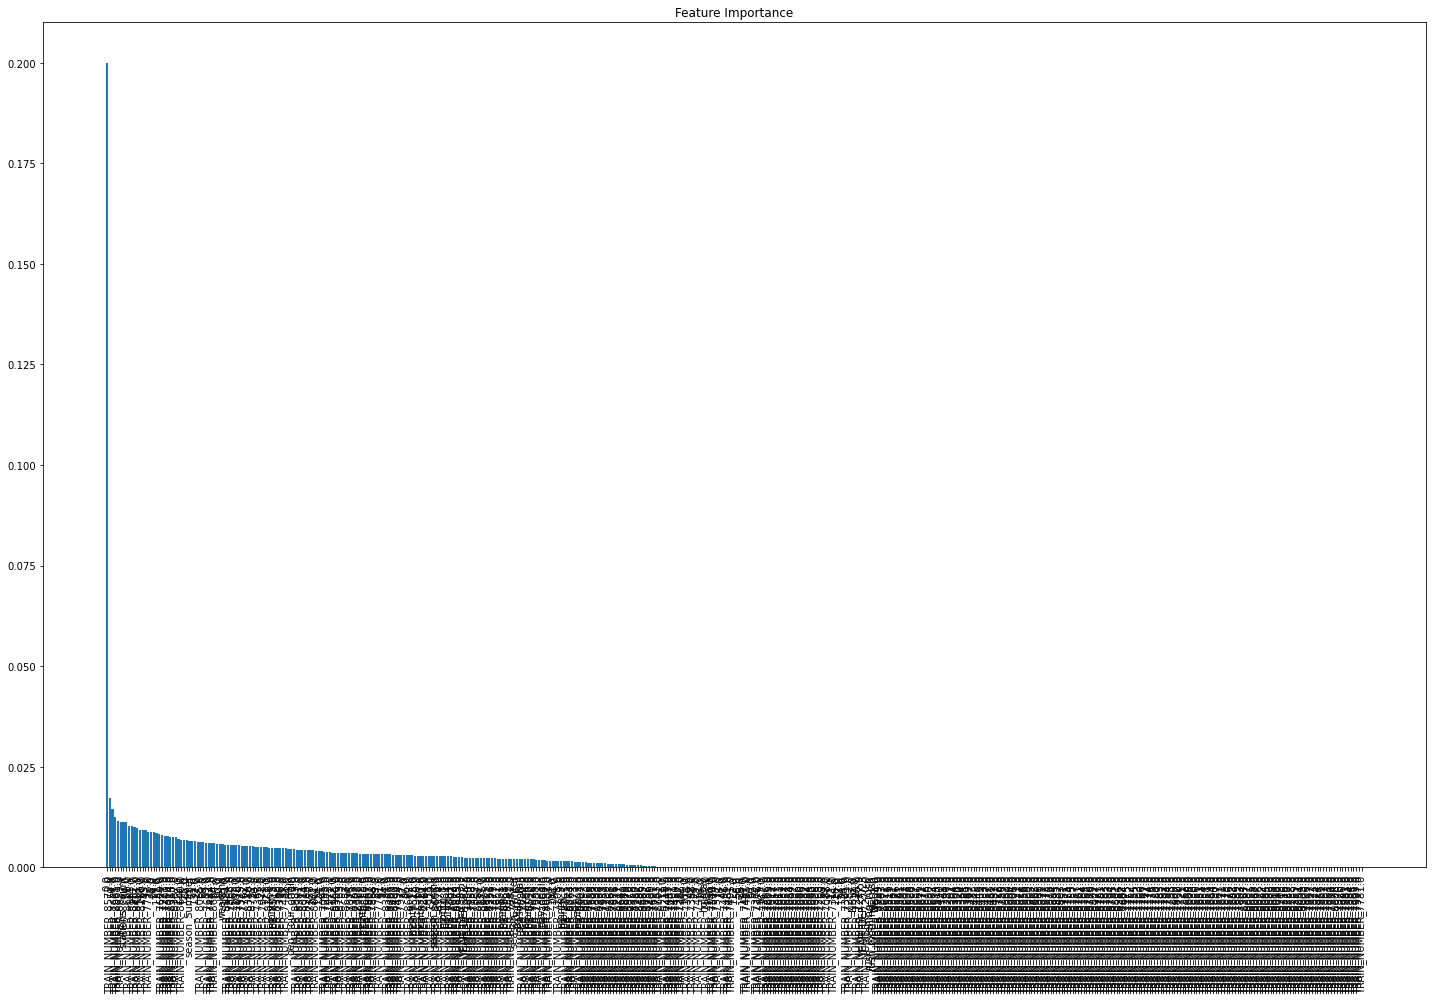

In [155]:
# Feature importances:

importances = xgbc.feature_importances_

sorted_indices = np.argsort(importances)[::-1]
 
fig, ax = plt.subplots(figsize=(20, 14)) 
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

In [159]:
# Predict the labels of the testing data
y_pred = xgbc.predict(X_test)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Predict the class probabilities for the testing data
y_pred_proba = xgbc.predict_proba(X_test)[:, 1]

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

print('Accuracy:', round(accuracy, 2))
print('Precision:', round(precision, 2))
print('Recall:', round(recall, 2))
print('F1 score:', round(f1, 2))
print(' - - - ')
print('AUC score:', round(auc_score, 2))

Accuracy: 0.89
Precision: 0.9
Recall: 0.99
F1 score: 0.94
 - - - 
AUC score: 0.79


In [160]:
# Create an explainer object for the random forest classifier
explainer = shap.TreeExplainer(xgbc)

# Calculate the SHAP values for a single instance
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


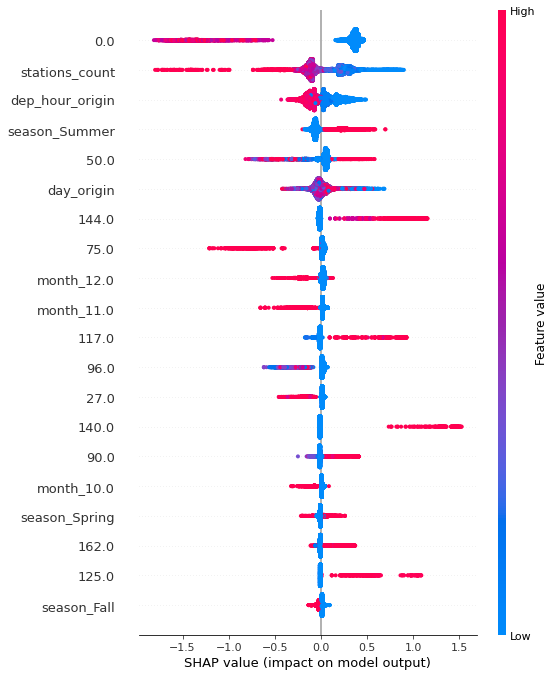

<Figure size 432x288 with 0 Axes>

In [161]:
# get summary plot
shap.summary_plot(shap_values, X_test)
plt.tight_layout()